In this notebook we will create a strategy for Bitcoin based on the Decision Tree Regressor.

In [2]:
from qf_lib.backtesting.trading_session.backtest_trading_session import BacktestTradingSession
from qf_lib.backtesting.strategies.abstract_strategy import AbstractStrategy
from qf_lib.backtesting.order.execution_style import MarketOrder
from qf_lib.backtesting.order.time_in_force import TimeInForce
from qf_lib.common.tickers.tickers import BinanceTicker

from sktime.forecasting.compose import (  # type: ignore
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.trend import PolynomialTrendForecaster  # type: ignore
from sktime.transformations.series.detrend import (  # type: ignore
    ConditionalDeseasonalizer,
    Detrender,
)

from sklearn.tree import DecisionTreeRegressor


class DecisionTreeRegressorStrategy(AbstractStrategy):
    def __init__(self, ts: BacktestTradingSession, ticker: BinanceTicker):
        super().__init__(ts)
        self.order_factory = ts.order_factory
        self.broker = ts.broker
        self.ticker = ticker
        self.timer = ts.timer
        self.data_handler = ts.data_handler

        degree = 1
        window_length = 7
        sp = 7
        deseasonal_model = "additive"
        regressor = DecisionTreeRegressor(random_state=123)

        self.forecaster = TransformedTargetForecaster(
            [
                (
                    "conditional_deseasonalise",
                    ConditionalDeseasonalizer(model=deseasonal_model, sp=sp),
                ),
                (
                    "detrend",
                    Detrender(forecaster=PolynomialTrendForecaster(degree=degree)),
                ),
                (
                    "forecast",
                    make_reduction(
                        estimator=regressor,
                        scitype="tabular-regressor",
                        window_length=window_length,
                        strategy="recursive",
                    ),
                ),
            ]
        )

    def calculate_and_place_orders(self):
        dates = date_range(start=self.timer.now(), freq="D", periods=5)

        prices_series = self.data_handler.historical_price(self.ticker, PriceField.Close, 600)
        prices_series = prices_series.dropna().asfreq('D').ffill()
        model = self.forecaster.fit(prices_series, fh=14)
        predicted_prices = model.predict(dates)

        last_price = self.data_handler.get_last_available_price(self.ticker)
        ma = predicted_prices.ewm(alpha=0.5).mean()

        if ma.iloc[-2] < ma.iloc[-1]:
            orders = self.order_factory.percent_orders({self.ticker: 0.1}, MarketOrder(), TimeInForce.GTC)
        else:
            orders = self.order_factory.percent_orders({self.ticker: -0.1}, MarketOrder(), TimeInForce.GTC)

        self.broker.place_orders(orders)

Now let's create a data provider with the daily Bitcoin prices:

In [3]:
from pathlib import Path
from qf_lib.data_providers.csv.csv_data_provider import CSVDataProvider
from qf_lib.common.enums.price_field import PriceField
from qf_lib.starting_dir import set_starting_dir_abs_path

ticker = BinanceTicker('BTC', 'USDT')

abs_path = Path().resolve()
set_starting_dir_abs_path(abs_path)
data_provider = CSVDataProvider(abs_path, ticker, 'Open time',
                                {'Close': PriceField.Close, 
                                 "Open": PriceField.Open, 
                                 "High": PriceField.High,
                                     "Low": PriceField.Low, 
                                 "Volume": PriceField.Volume},
                                ['Close', 'Open', 'High', 'Low', 'Volume'])


Now we can create a trading session using the BacktestTradingSessionBuilder, define the strategy, schedule to run it every day and start the simulation.

MarketOpenEvent was set by default to 13:30 and MarketCloseEvent to 20:00. If you want to change the default market open or close time use the set_market_open_and_close_time function of the BacktestTradingSessionBuilder.
TearsheetWithoutBenchmark will be generated without a logo in the header. If you would like to include your logo, add 'logo_path' variable to your JSON settings file. 
TearsheetWithoutBenchmark will be generated without a company name in the header. If you would like to include your company name, add 'company_name' variable to your JSON settings file. 
TearsheetWithoutBenchmark will be generated without a logo in the header. If you would like to include your logo, add 'logo_path' variable to your JSON settings file. 
TearsheetWithoutBenchmark will be generated without a company name in the header. If you would like to include your company name, add 'company_name' variable to your JSON settings file. 
PortfolioAnalysisSheet will be generated without a logo in the header

                         DecisionTreeRegressorStrategy
Start Date                         2021-12-02 
End Date                           2021-12-31 
Total Return                           -11.33 %
Annualised Return                      -76.87 %
Annualised Volatility                   42.32 %
Annualised Upside Vol.                  25.86 %
Annualised Downside Vol.                34.48 %
Sharpe Ratio                            -3.46 
Omega Ratio                              0.67 
Calmar Ratio                            -6.36 
Gain to Pain Ratio                      -1.00 
Sorino Ratio                            -2.23 
5% CVaR                                 -6.13 %
Annualised 5% CVaR                     -63.39 %
Max Drawdown                            12.09 %
Avg Drawdown                             5.19 %
Avg Drawdown Duration                   15.00 days
Best Return                              5.82 %
Worst Return                            -8.36 %
Avg Positive Return                  

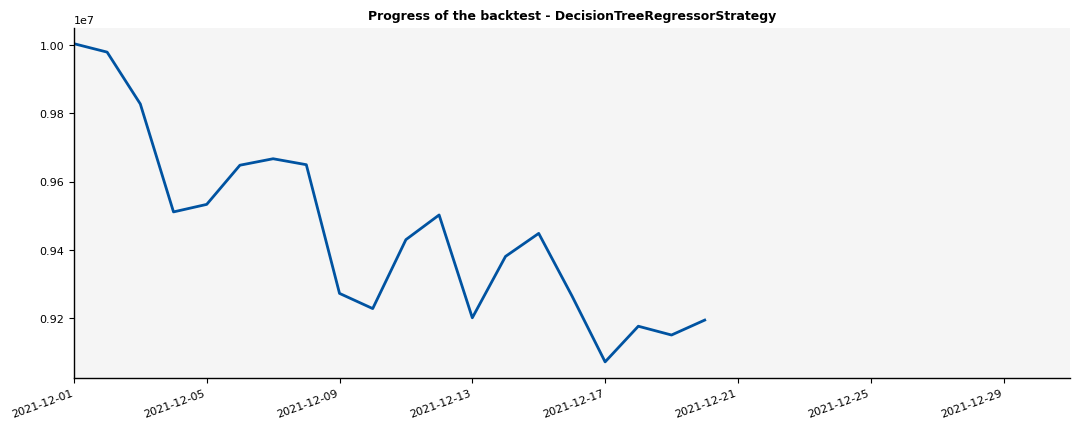

In [6]:
from datetime import datetime 
from qf_lib.settings import Settings
from qf_lib.backtesting.trading_session.backtest_trading_session_builder import BacktestTradingSessionBuilder
from qf_lib.documents_utils.document_exporting.pdf_exporter import PDFExporter
from qf_lib.documents_utils.excel.excel_exporter import ExcelExporter
from qf_lib.common.enums.frequency import Frequency
from qf_lib.backtesting.events.time_event.regular_time_event.calculate_and_place_orders_event import \
    CalculateAndPlaceOrdersRegularEvent
from qf_lib.backtesting.execution_handler.commission_models.bps_trade_value_commission_model import \
    BpsTradeValueCommissionModel
from qf_lib.backtesting.execution_handler.slippage.price_based_slippage import PriceBasedSlippage

from pandas import date_range

start_date = datetime(2021, 12, 1)
end_date = datetime(2021, 12, 31)
settings = Settings('settings.json')
session_builder = BacktestTradingSessionBuilder(settings, PDFExporter(settings), ExcelExporter(settings))
session_builder.set_backtest_name('DecisionTreeRegressorStrategy')
session_builder.set_data_provider(data_provider)
session_builder.set_frequency(Frequency.DAILY)
# session_builder.set_commission_model(BpsTradeValueCommissionModel, commission=3.0)
# session_builder.set_slippage_model(PriceBasedSlippage, slippage_rate=0.01)

ts = session_builder.build(start_date, end_date)

strategy = DecisionTreeRegressorStrategy(ts, ticker)
CalculateAndPlaceOrdersRegularEvent.set_daily_default_trigger_time()
strategy.subscribe(CalculateAndPlaceOrdersRegularEvent)

ts.start_trading()